## Design matrix for sub-trial HMM

In [2]:
import os
import numpy as np
from one.api import ONE
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import brainbox.behavior.wheel as wh
from scipy.stats import zscore

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_raw_and_smooth_position, get_dlc_XYs, get_lick_times, get_pupil_diameter, get_ME, keypoint_speed, pupil_center
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

### Get sessions from mice of interest

In [24]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
#data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))
example_session = list(pass_qc)[0]

### Parameters

In [25]:
bin_size = 0.1  # seconds

### Session-specific data

In [26]:
# TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries

one = ONE()
video_type = 'left'
example_session = 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9'  #'cb2ad999-a6cb-42ff-bf71-1774c57e5308'

# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = session_trials.to_df()

# Licks
session_licks = get_lick_times(example_session, combine=False, video_type=video_type)

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

# Pupil diameter
pupil_dia_raw, pupil_dia_smooth, _, _ = (
    get_raw_and_smooth_position(example_session, video_type, ephys=True, position_function=get_pupil_diameter))
pupil_t, XYs = get_dlc_XYs(example_session, view=video_type, likelihood_thresh=0.9)

# Motion energy of whisker pad
me_times, motion_energy = get_ME(example_session, video_type)       
motion_energy = zscore(motion_energy, nan_policy='omit') 

# Nose velocity
nose_speeds = keypoint_speed(example_session, True, 'nose_tip', True)
nose_times = nose_speeds['left'][0][1:]
nose_speed_X = nose_speeds['left'][1]
nose_speed_Y = nose_speeds['left'][2]

## Right paw velocity
#right_p_speeds = keypoint_speed(example_session, True, 'paw_r', True)
#right_p_times = right_p_speeds['right'][0][1:]
#right_p_speed_X = right_p_speeds['right'][1]
#right_p_speed_Y = right_p_speeds['right'][2]

# Left paw velocity
left_p_speeds = keypoint_speed(example_session, True, 'paw_r', True)
left_p_times = left_p_speeds['left'][0][1:]
left_p_speed_X = left_p_speeds['left'][1]
left_p_speed_Y = left_p_speeds['left'][2]

# Pupil velocity
pupil_speeds = keypoint_speed(example_session, True, pupil_center, True)
pupil_times = pupil_speeds['left'][0][1:]
pupil_speed_X = pupil_speeds['left'][1]
pupil_speed_Y = pupil_speeds['left'][2]

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:463: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:464: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:463: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:464: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


In [6]:
session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']

# Initialize dataframe

licking = lick_rate(bin_size, session_licks, session_trials)
wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
#wheel_disp_norm = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
nose_vel_X = cont_bin(nose_times, nose_speed_X, session_trials, bin_size)
nose_vel_Y = cont_bin(nose_times, nose_speed_Y, session_trials, bin_size)
#right_vel_X = cont_bin(right_p_times, right_p_speed_X, session_trials, bin_size)
#right_vel_Y = cont_bin(right_p_times, right_p_speed_Y, session_trials, bin_size)
left_vel_X = cont_bin(left_p_times, left_p_speed_X, session_trials, bin_size)
left_vel_Y = cont_bin(left_p_times, left_p_speed_Y, session_trials, bin_size)
pupil_vel_X = cont_bin(pupil_times, pupil_speed_X, session_trials, bin_size)
pupil_vel_Y = cont_bin(pupil_times, pupil_speed_Y, session_trials, bin_size)

In [20]:
pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})

nose_vel_X = nose_vel_X.rename(columns={'Values':'nose_speed_X'})
nose_vel_Y = nose_vel_Y.rename(columns={'Values':'nose_speed_Y'})

#right_vel_X = right_vel_X.rename(columns={'Values':'r_paw_speed_X'})
#right_vel_Y = right_vel_Y.rename(columns={'Values':'r_paw_speed_Y'})

left_vel_X = left_vel_X.rename(columns={'Values':'l_paw_speed_X'})
left_vel_Y = left_vel_Y.rename(columns={'Values':'l_paw_speed_Y'})

pupil_vel_X = pupil_vel_X.rename(columns={'Values':'pupil_speed_X'})
pupil_vel_Y = pupil_vel_Y.rename(columns={'Values':'pupil_speed_Y'})
#wheel_disp_norm = wheel_disp_norm.rename(columns={'wheel_final':'wheel_disp_norm'})

In [16]:
all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
#all_metrics = all_metrics.merge(wheel_disp_norm[['Bin', 'wheel_disp_norm']], on='Bin', how='outer')
all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')
all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
all_metrics = all_metrics.merge(nose_vel_X[['Bin', 'nose_speed_X']], on='Bin', how='outer')
all_metrics = all_metrics.merge(nose_vel_Y[['Bin', 'nose_speed_Y']], on='Bin', how='outer')

#all_metrics = all_metrics.merge(right_vel_X[['Bin', 'r_paw_speed_X']], on='Bin', how='outer')
#all_metrics = all_metrics.merge(right_vel_Y[['Bin', 'r_paw_speed_Y']], on='Bin', how='outer')

all_metrics = all_metrics.merge(left_vel_X[['Bin', 'l_paw_speed_X']], on='Bin', how='outer')
all_metrics = all_metrics.merge(left_vel_Y[['Bin', 'l_paw_speed_Y']], on='Bin', how='outer')

all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
all_metrics = all_metrics.dropna().drop_duplicates()

In [17]:
new = all_metrics.merge(pupil_vel_X[['Bin', 'pupil_speed_X']], on='Bin', how='outer')
new = new.merge(pupil_vel_Y[['Bin', 'pupil_speed_Y']], on='Bin', how='outer')

In [18]:
all_metrics = new.copy()
all_metrics = all_metrics.dropna().drop_duplicates()

To transform Poisson data into a Gaussian (normal) distribution, you can use a square root transformation or the Anscombe transformation. These transformations are common methods used to approximate a normal distribution from Poisson data.
- Square Root Transformation: The square root transformation is a simple method to stabilize the variance of Poisson data and make it more approximately Gaussian. For each data point x, you take the square root of x:

- Anscombe Transformation: The Anscombe transformation is a more sophisticated transformation that stabilizes the variance and approximates the normal distribution for Poisson data. It is defined as:

In [22]:
# Transform licks
def anscombe_transform(x):
    return 2 * np.sqrt(x + 3/8)
all_metrics['Gaussian_licks'] = anscombe_transform(all_metrics['Lick count'])
all_metrics['Gaussian_licks'] = np.sqrt(all_metrics['Lick count'])

In [23]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix'

os.chdir(data_path)

pickle.dump(all_metrics, open("design_matrix_v2_" + str(example_session) + '_' + str(bin_size), "wb"))

In [32]:
#clean_df = all_metrics[['Bin', 'Lick count', 'avg_wheel_vel', 'wheel_final', 'pupil_final', 'Onset times']].dropna()
clean_df = all_metrics[['Bin', 'avg_wheel_vel', 'Lick count', 'Onset times', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']].dropna().drop_duplicates()


### Covariance matrix

In [55]:
cov_df = all_metrics[['avg_wheel_vel', 'Lick count', 'Onset times', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y']].dropna().drop_duplicates()


In [56]:
cov = cov_df.corr()

Text(0.5, 1.0, 'Correlation Matrix')

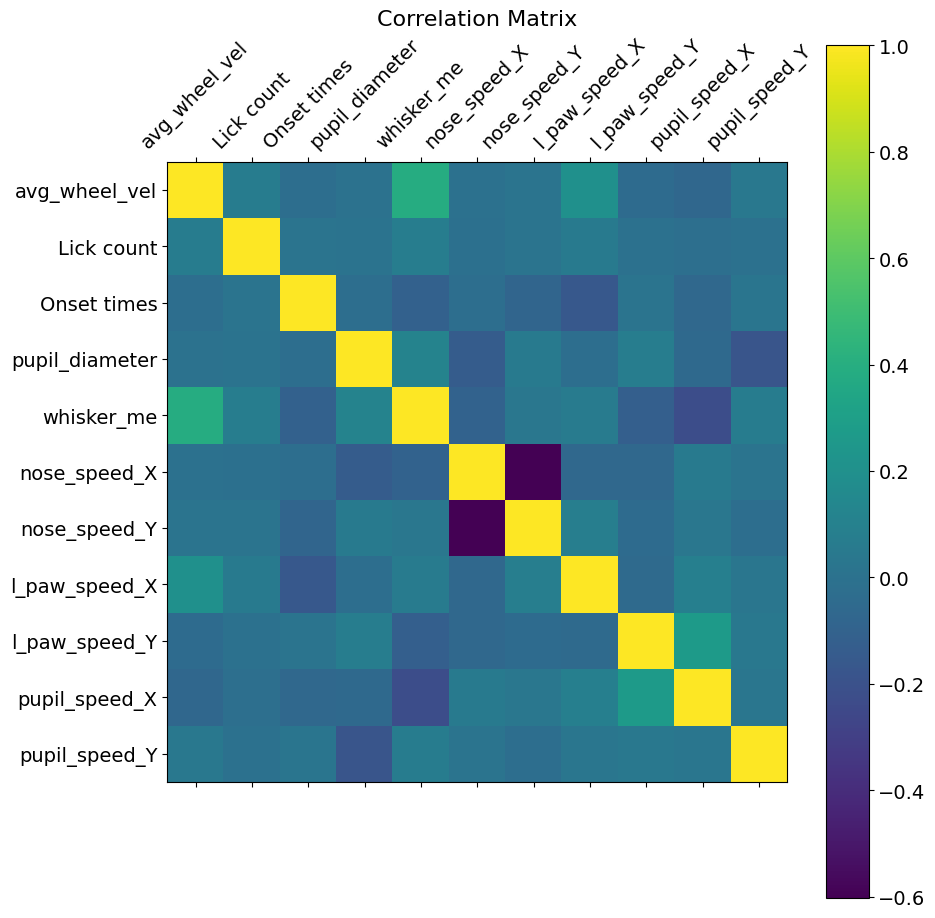

In [59]:
f = plt.figure(figsize=(10, 11))
plt.matshow(cov, fignum=f.number)
plt.xticks(range(11), cov_df.columns, fontsize=14, rotation=45)
plt.yticks(range(11), cov_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

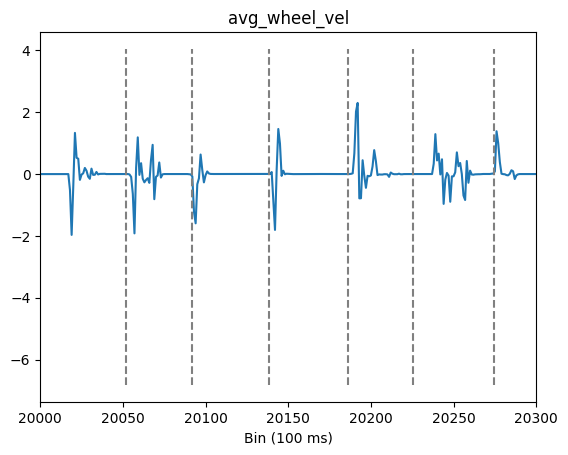

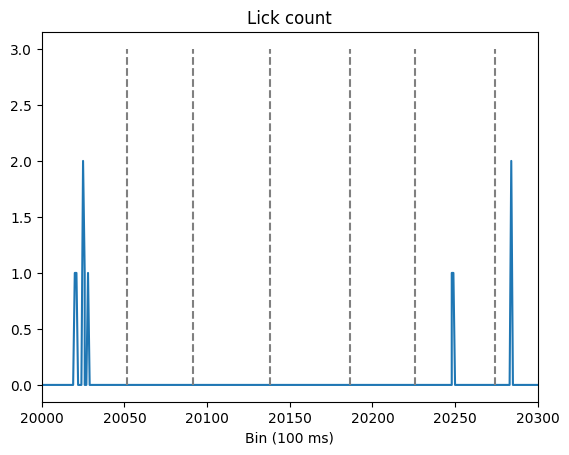

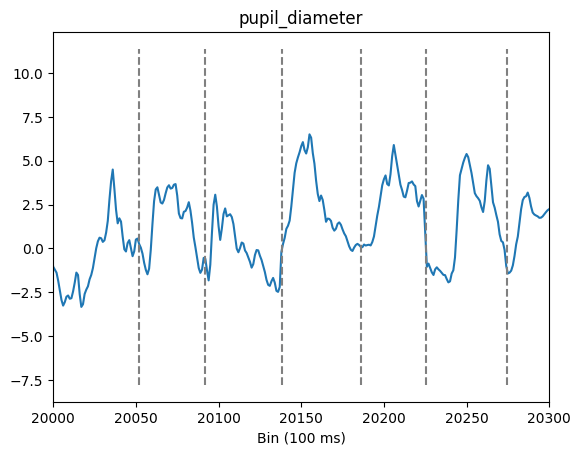

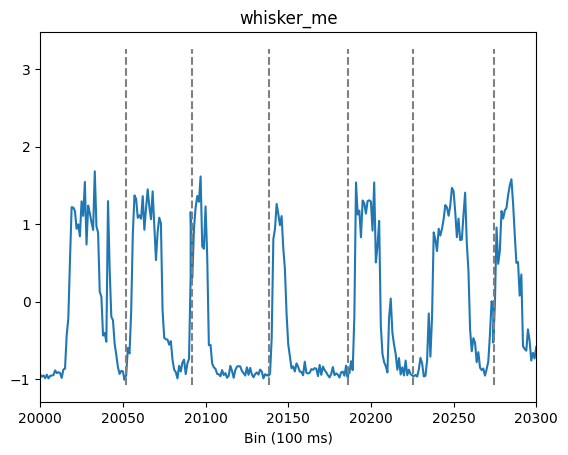

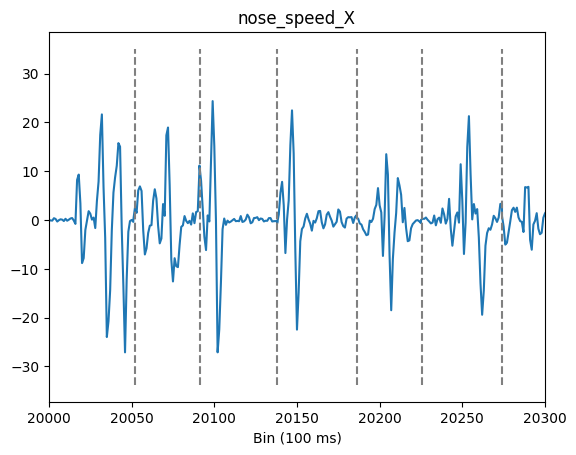

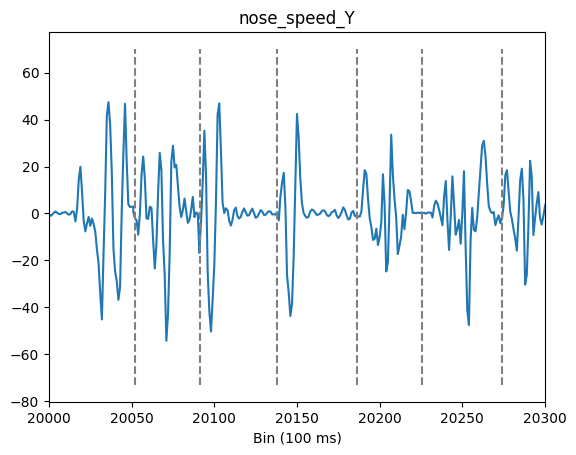

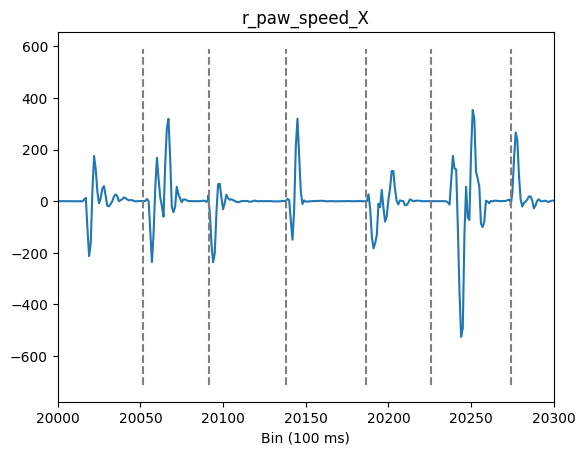

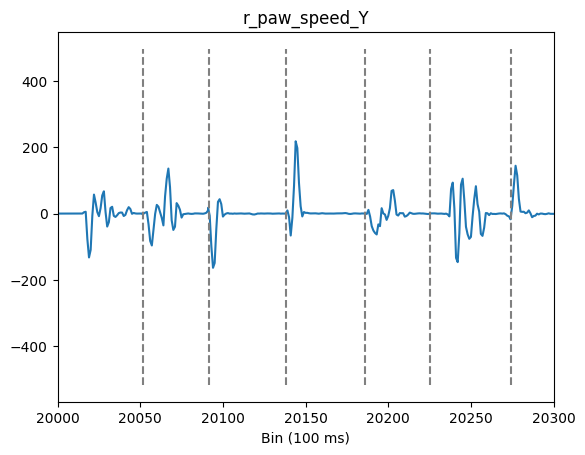

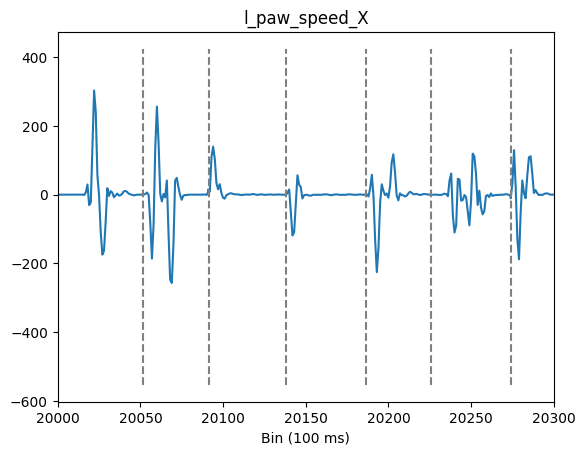

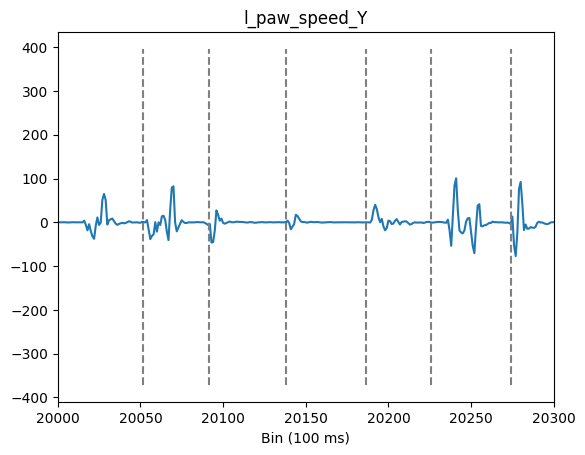

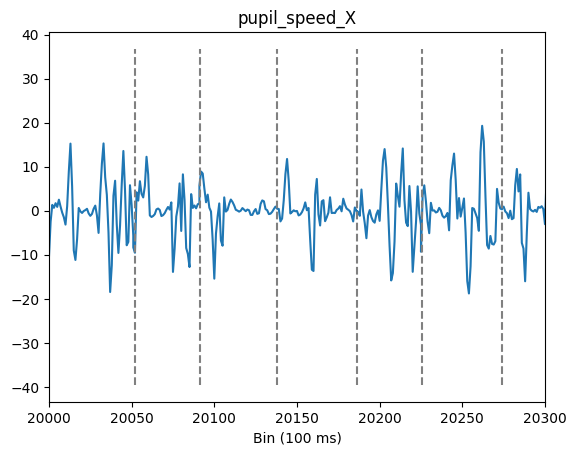

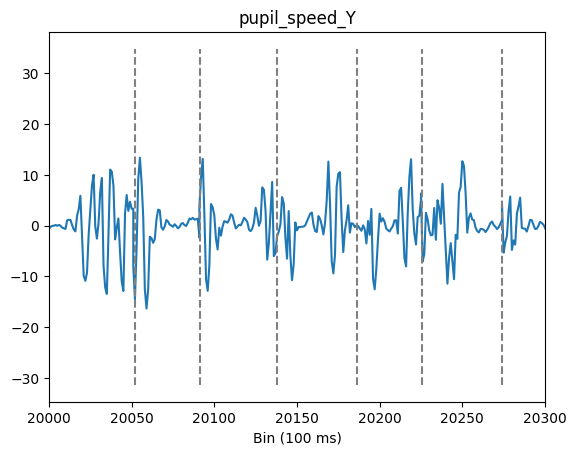

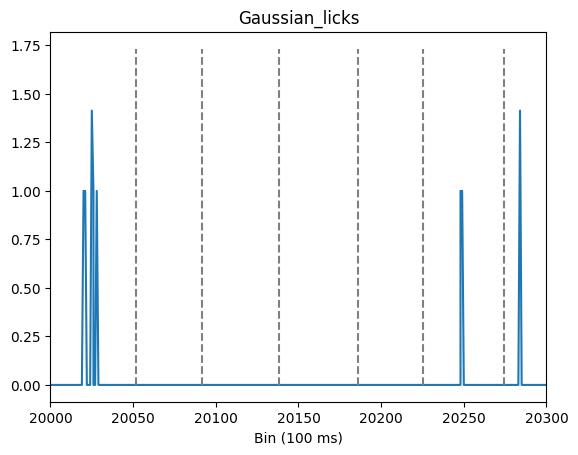

In [25]:
keys = ['avg_wheel_vel', 'Lick count', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 'r_paw_speed_X',
       'r_paw_speed_Y', 'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']

fig, ax = plt.subplots(nrows=1, ncols=len(keys), sharex=False, sharey=True, figsize=[20, 4.5])

for k, key in enumerate(keys):
    
    plt.plot(clean_df['Bin'], clean_df[key], ax = ax[k])
    ax[k].set_xlim([20000, 20300])
    plt.vlines((clean_df['Onset times'].unique() *10), np.min(clean_df[key]), np.max(clean_df[key]), color='gray', linestyles='--', ax=ax[k])
    ax[k].set_xlabel('Bin (100 ms)')
    ax[k].set_title(key)
    plt.show()


In [ ]:
# Compute the most likely states
init = 1000 + len(use_val)*(use_fold-1)
end = 1500 + len(use_val)*(use_fold-1)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
axs.plot(design_matrix['Bin'], design_matrix['pupil_final'], label='Pupil diameter')
axs.plot(design_matrix['Bin'], design_matrix['avg_wheel_vel'], label='Wheel velocity')
axs.plot(design_matrix['Bin'], design_matrix['wheel_disp_norm'], label='Wheel displacement')

axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 7.5)

axs.set_ylabel("")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("")
plt.legend()
plt.tight_layout()


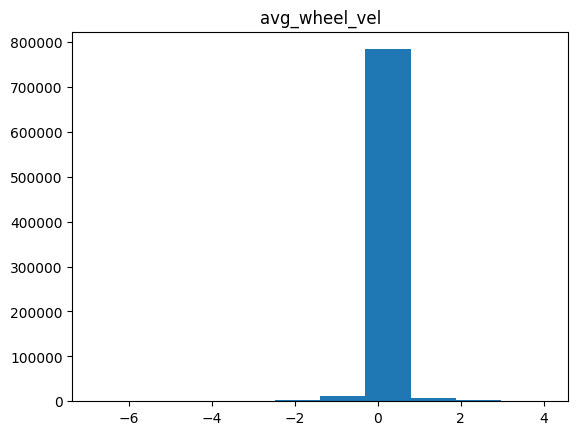

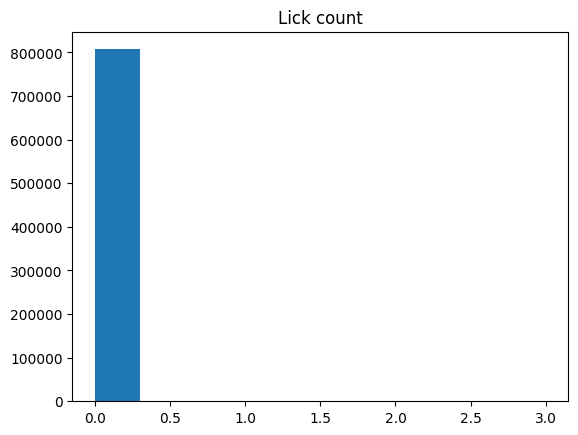

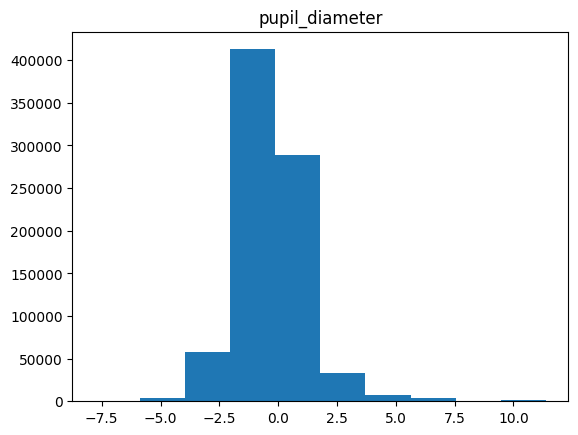

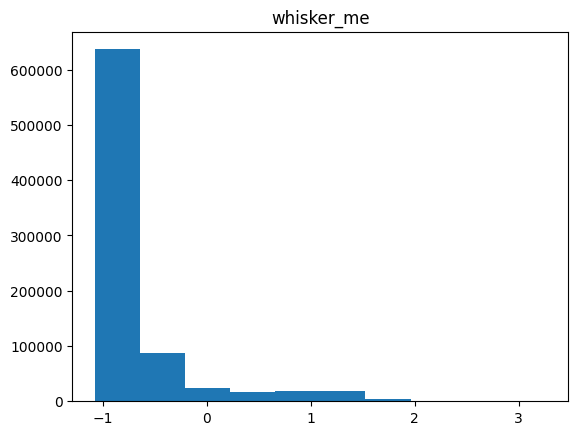

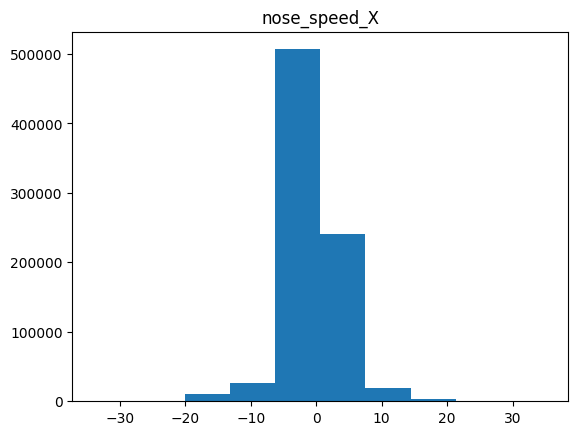

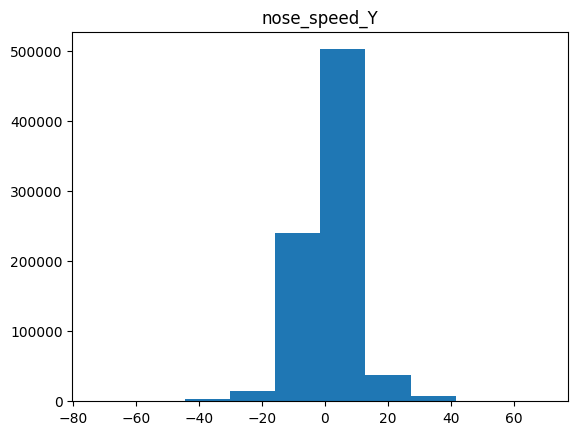

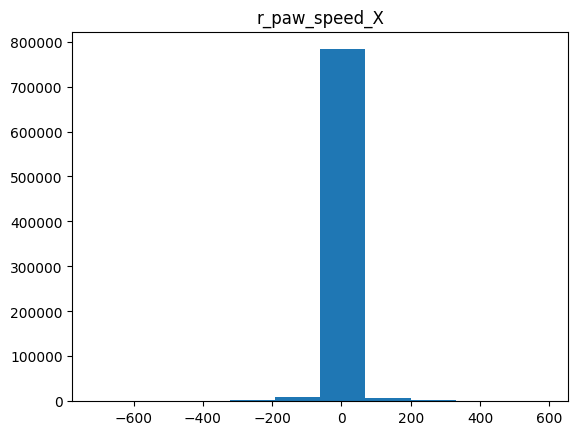

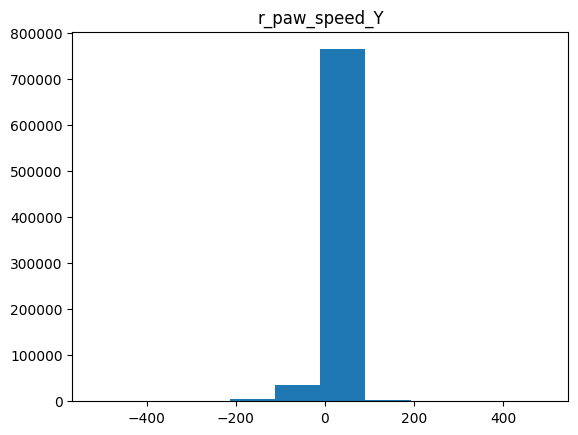

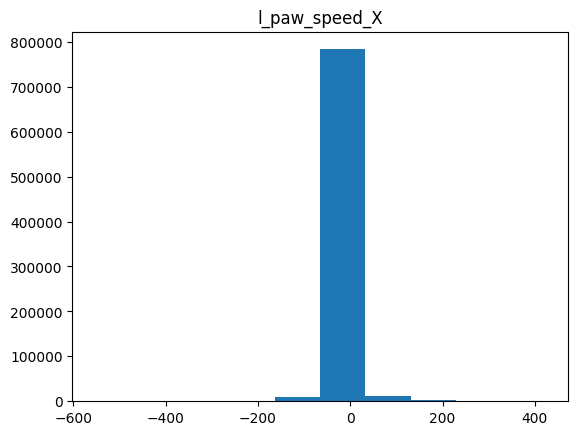

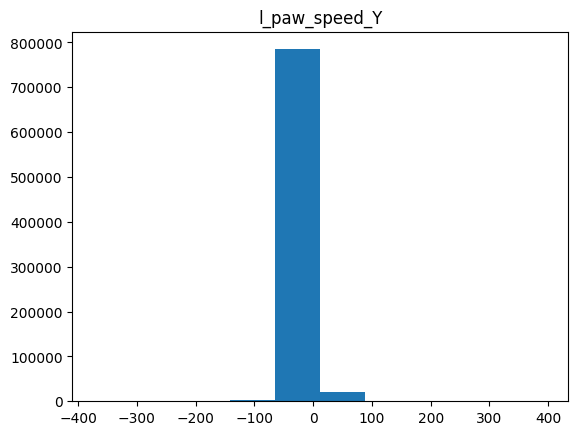

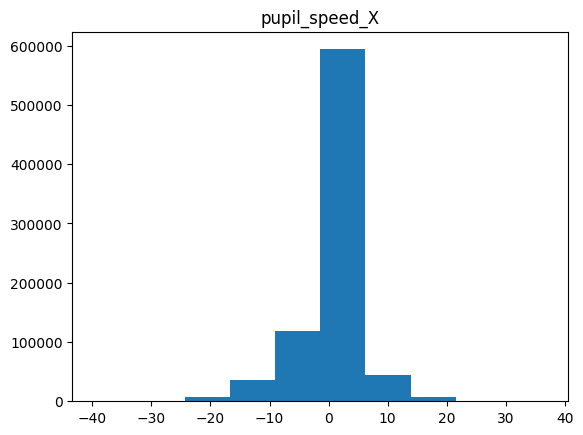

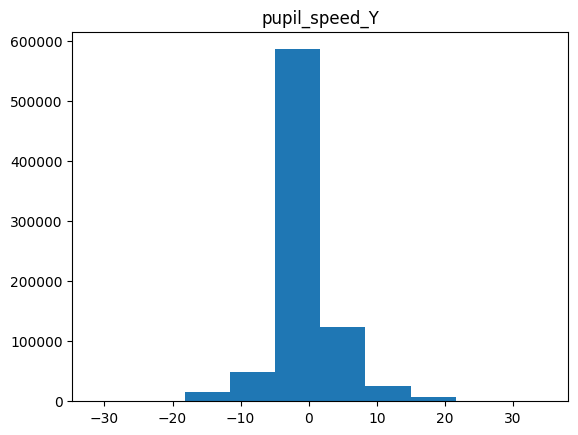

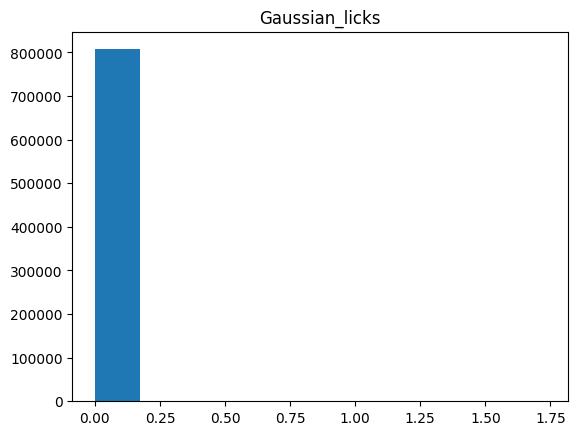

In [28]:
keys = ['avg_wheel_vel', 'Lick count', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 'r_paw_speed_X',
       'r_paw_speed_Y', 'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']

for k, key in enumerate(keys):
    
    plt.hist(clean_df[key])
    plt.title(key)
    plt.show()
